# **EXPLORING THE TOP 5 DEADLIEST LOCATIONS OF ACCIDENTS / INCIDENTS IN AVIATION SINCE 1923**

**Bienvenu CHOUPO  
June 18, 2019**

## 1. **INTRODUCTION**

Air transport is in a substancial growth nowadays especially in developping countries (Africa). 
People need to do a lot of things in a small amount of time. The age of speed indeed !  
Plane crash is scarce, but once it happens, it can be very serious. Over the years, there have been some serious cases of aircraft incidents / accidents  that resulted in loss of many lives.
Those accidents happened in various locations around the globe and involved many airlines companies and different types of aircrafts.  
More often, to keep the souvenir of the victims, memorials for crash victims are built. Those memorial attract many people, especially tourists. For a place to attract tourists, there needs to be some common facilities: hotel, restaurant, museum, historical site...

**Let's say a tourist would like to visit one of the top five locations where air crash killed the most people, but don't know which one to choose and ask for suggestions.** 

In this notebook, we will explore the data of accidents from 1923 to 2019. Analysing the data, we will retrieve the top 5 locations where most people were killed. We will then use the Foursquare API to explore those locations, cluster the neighborhoods of those locations and make suggestions to tourist. 

## 2. **DATA**

The data have been extracted from the wiki page:  
https://en.wikipedia.org/wiki/List_of_aircraft_accidents_and_incidents_resulting_in_at_least_50_fatalities using the BeautifulSoup package. The data cover a period from 1923-12-21 to 2019-03-10.  
**Inclusion criteria**  
Criteria for inclusion require at least 50 fatalities in a single occurrence involving commercial passenger and cargo flights, military passenger and cargo flights, or general aviation flights that have been involved in a ground or mid-air collision with either a commercial or military passenger or cargo flight.  

On the website page, only the names of locations are given. In order to get information on the geographical coordinates of various locations, I will use the geocoder package.  It will not be easy due to the fact that many locations’ names are not written so as to get the geocoder retrieve their coordinates. So I need to refine the names.   
After having all the information, I will save the data in a csv file (Air_Accident.csv) so that the data can be accessible easily.

Foursquare API location will be used for exploring the neighborhood of the top 5 locations were most people were killed in air crash.


Let's first import all libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values


import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# For scrapping tables from the web
from bs4 import BeautifulSoup
import codecs

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import datetime

print('Libraries imported.')

Libraries imported.


Let's ping the website

In [2]:
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_aircraft_accidents_and_incidents_resulting_in_at_least_50_fatalities').text

Now we Scrape a table from the website using  BeautifulSoup package

In [3]:
soup = BeautifulSoup(website_url,'lxml')
tables = soup.find_all("table", { "class" : "wikitable" })

How many tables are there on the web page?

In [6]:
print('There are ',len(tables),' tables on the website')

There are  6  tables on the website


Table number 3 is the one that interests us. the first two are just informative, they are table keys.

####  2.1. **Extraction of Tables from the website**

On the website we have multiple tables, exactly 6:
We are interested in the first 3:
Table key (deaths, type) which is table[0]
Table key (location, phase of flight)  which is table[1]
List of aircraft accidents and incidents resulting in 50 or more fatalities which is table[2].
table[2] is a little difficult to extract once, so we'll do it in two phases.

In [54]:
#Write a function to parse the rows and the cells and save them in a 2-D array.
def parse(n):
    data = []
    for row in tables[n].find_all("tr"):
        if row and row.find_all('td'):
            data_row = []
            cells = row.find_all('td')
            for cell in cells:
                if cell:
                    data_row.append(cell.get_text().rstrip())            
            data.append(data_row)
    return data

01. Let's extract the table key (Death, type) and name the dataframe Key_death.   
For that, we call the function parse with argument 0

In [7]:
key_death = pd.DataFrame(parse(0),columns = ['Abbreviation', 'Definition','Total']) 
key_death.shape

(13, 3)

In [8]:
key_death.head()

,Abbreviation,Definition,Total
0,Deaths,Tot,Total
1,C,Crew,None
2,P,Passenger,None
3,G,Ground,None
4,N,Notes,None


Let's rearrange row index 7

In [9]:
key_death.iloc[7,:] = [key_death.loc[7,'Definition'], key_death.loc[7,'Total'], 'None']

Let's drop the first row (index=0) and the column 'Total' which is useless here

In [10]:
#drop index 0
key_death = key_death.drop(index=0)
#drop column 'Total'
key_death = key_death.drop(['Total'],axis=1)

In [11]:
key_death

,Abbreviation,Definition
1,C,Crew
2,P,Passenger
3,G,Ground
4,N,Notes
5,†,No survivors
6,1*,Sole survivor
7,COM,Commercial (accident/incident)
8,MIL,Military (accident/incident)
9,INB,Bombing
10,INH,Hijacking


02. Now Let's extract the table key  (location, phase of flight) and name the dataframe Key_location.   
For that, we call the function parse with argument 1

In [55]:
key_location = pd.DataFrame(parse(1),columns = ['Abbreviation', 'Definition','Total']) 
key_location.shape

(14, 3)

In [42]:
key_location

,Abbreviation,Definition,Total
0,Location,(none),< 20 km (12.5 mi)
1,"""off""",< 20 km (12.5 mi) (water impact),None
2,"""near""",20 km (12.5 mi) to 50 km (31 mi),None
3,"""area of""",> 50 km (31 mi),None
4,Phase,STD,Standing
5,TXI,Taxi,None
6,TOF,Take off,None
7,ICL,Initial climb,None
8,ENR,En route,None
9,MNV,Maneuvering,None


Let's rearrange rows with index 0, 4 and 13 and drop column 'total

In [56]:
# Drop indexes
for i in (0, 4, 13):
    key_location.iloc[i,:] = [key_location.loc[i,'Definition'], key_location.loc[i,'Total'], 'None'] 

key_location.head()

,Abbreviation,Definition,Total
0,(none),< 20 km (12.5 mi),None
1,"""off""",< 20 km (12.5 mi) (water impact),None
2,"""near""",20 km (12.5 mi) to 50 km (31 mi),None
3,"""area of""",> 50 km (31 mi),None
4,STD,Standing,None


Column 'Total'is useless. Let's remove it

In [57]:
key_location = key_location.drop(['Total'],axis=1)

key_location looks then like this:

In [58]:
key_location

,Abbreviation,Definition
0,(none),< 20 km (12.5 mi)
1,"""off""",< 20 km (12.5 mi) (water impact)
2,"""near""",20 km (12.5 mi) to 50 km (31 mi)
3,"""area of""",> 50 km (31 mi)
4,STD,Standing
5,TXI,Taxi
6,TOF,Take off
7,ICL,Initial climb
8,ENR,En route
9,MNV,Maneuvering


Let's now deal with the main table: List of aircraft accidents and incidents resulting in 50 or more fatalities.  
We will make it in two steps.  
First, let's extract the table "df1" of the list of accidents.  
Second, we extract the table "death" of the total number of death on each accident.  
Then we join the two tables to build our main dataframe

In [14]:
#let's extract the table "df1" of the list of accidents. We call the function parse with argument 2 
df1 = pd.DataFrame(parse(2), columns = ['Type','Incident','Aircraft','Location','Phase','Airport','Distance','Date']) 
df1.shape

(548, 8)

In [ ]:
df1.head(20)

In [15]:
# Let's extract the table "death" of the total number of death on each accident.
# We proceed a little bit differently as this table is not shaped the same way as the others.

data = []
for row in tables[2].find_all("tr"): # still on tables[2]
    if row and row.find_all('td'):
        data_row = []
        cells = row.find_all('th') # Here's the difference with the others
        for cell in cells:
            if cell:
                data_row.append(cell.get_text().rstrip())            
        data.append(data_row)
        
death = pd.DataFrame(data, columns = ['Total','Crew','Passenger','Ground','Notes']) 
death.shape

(548, 5)

In [ ]:
death.head()

We can now built our main dataframe "df" by concatenating the two above.

In [17]:
df = pd.concat([df1, death], axis=1)
df.head()

,Type,Incident,Aircraft,Location,Phase,Airport,Distance,Date,Total,Crew,Passenger,Ground,Notes
0,INH,American Airlines Flight 11,Boeing 767-223ER,"usnewyneNew York City, New York, U.S.",ENR[11],,,2001-09-11,"est. 1,700",11,81,"est. 1,600[nb 2]",†
1,INH,United Airlines Flight 175,Boeing 767-222,"usnewyneNew York City, New York, U.S.",ENR[12],,,2001-09-11,"est. 1,000",9,56,est. 900[nb 2],†
2,COM,Pan Am Flight 1736 andKLM Flight 4805,Boeing 747-121 and Boeing 747-206B,"spctTenerife, Spain",TXI/TOF[10][16][17],TFN,,1977-03-27,583,23,560,0,
3,COM,Japan Airlines Flight 123,Boeing 747SR-46,"juUeno, Japan",ENR[18][19],,,1985-08-12,520,15,505,0,
4,COM,Saudi Arabian Flight 763 andKazakhstan Airline...,Boeing 747-168B and Ilyushin Il-76TD,"indicCharkhi Dadri, India",ENR[20][21],,,1996-11-12,349,33,316,0,†


Let's its shape:

In [136]:
df.shape

(548, 15)

Let's find out whether there are duplicate entries or not.

In [18]:
df[df.duplicated()]

,Type,Incident,Aircraft,Location,Phase,Airport,Distance,Date,Total,Crew,Passenger,Ground,Notes


The results show that each row is unique, which is good.

#### 2.2. **Let's search for the location coordinates**

In [19]:
df.Location.head()

0    usnewyneNew York City, New York, U.S.
1    usnewyneNew York City, New York, U.S.
2                      spctTenerife, Spain
3                            juUeno, Japan
4                indicCharkhi Dadri, India
Name: Location, dtype: object

We see that there are some useless letters in lower cases at the beginning of the locations, 
we need to delete them

In [15]:
# We delete the first non capital letters  
v = df.Location
for i in range (len(df)) :
    s = df.Location[i]
    r=len(s)
    j=0
    while s[j].islower():
        v[i] = s[j+1:r]
        j=j+1

# Set the Locations        
df.Location = v

* #### Get the Coordinates

Let's add the columns 'Latitude' and 'Longitude' to the dataframe

In [16]:
# define new empty columns
df['Latitude'] = np.nan
df['Longitude'] = np.nan

* #### We use geopy library to get the latitude and longitude values of Locations.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [17]:
# Create a function getlocation to retrieve the geographic coordinates
def getlocation(my_data): # my_data is a dataframe
    # Initialization
    latitude = my_data.Latitude
    longitude = my_data.Longitude
    # Assign the coordinates
    for i in my_data.index : # formerly for i in range (len(my_data))
        address = my_data.Location[i]
        # Use the Geocode
        try:
            geolocator = Nominatim(user_agent="ny_explorer")
            loc = geolocator.geocode(address)
            latitude[i] = loc.latitude
            longitude[i] = loc.longitude
        except:
            print('Error on Location ',i)
    
    print('Coordinates Found: ',len(my_data[my_data['Latitude'].notnull()].index))
    print('Still missing: ',len(my_data[my_data['Latitude'].isnull()].index))

We call the function getlocation on our dataframe df

In [ ]:
getlocation(df)

We have found 358 locations out of 548. There are 190 missing.

* ### Let's deal with missing values

Let's split our dataframe into two:  
One (df_miss0) with the correct coordinates, the other df_miss1 made of the missing values.
At the end we will just need to merge the dataframes to rebuilt the whole one.

In [19]:
df_miss0 = df[df['Latitude'].notnull()]
df_miss1 = df[df['Latitude'].isnull()]

Let's refine the names of locations in order to get the geocoder have their geographic coordinates

In [20]:
# We remove the first characters until we reach the character 'char' 
# as we will probably repeat this operation several times in order to get the various locations  
# Let's define a function refine()

def refine(database, char):
    for i in database.index :
        try:
            while (database.loc[i,'Location'][0] != char):
                r=len(database.loc[i,'Location']) # La longueur de la chaine de caractères 'Location' ligne i, colonne j
                database.loc[i,'Location'] = database.loc[i,'Location'][1:r]
            if database.loc[i,'Location'][0] == char : # Go to the beginning of the string, no space
                r=len(database.loc[i,'Location'])
                database.loc[i,'Location'] = database.loc[i,'Location'][1:r]
        except:
            print('error on index ',i)
    
    print('Operation complete')

In [ ]:
#Let's call the function on 'df_miss' and 'coma'
refine(df_miss1," ")
# Nota: this operation takes some time to compete

/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


We see from the result that there's a problem on indexes 52 and 361. Let's deal with it right away!

In [ ]:
# df.loc[52,'Location'] = "Gulf of Guineaoff Côte d'Ivoire"
# df.loc[361,'Location'] = 'Central America[nb 27]'
# We set the values manually, knowing that the geocoder works well on those values
df_miss1.loc[52,'Location'] = "Côte dIvoire"
df_miss1.loc[361,'Location'] = 'Central America'

Good! We now call the function getlocation on df_miss1 to have the coordinates.

In [ ]:
getlocation(df_miss1)

We have found 95 coordinates, but there are still 96 missing. We split the dataframe again

In [ ]:
df_miss1_0 = df_miss1[df_miss1['Latitude'].notnull()] # with coordinates
df_miss2 = df_miss1[df_miss1['Latitude'].isnull()] # with no coordinates

Let's repeat the previous process again:  

In [ ]:
# Call the function refine
refine(df_miss2," ")

In [ ]:
# call the function getlocation
getlocation(df_miss2)

No new coordinates found. Let's call refine and getlocation again! (Never give up!!!)

In [ ]:
# Call the function refine
refine(df_miss2," ")

In [ ]:
# call the function getlocation
getlocation(df_miss2)

25 Coordinates found and 71 still missing. Let's split the dataframe and repeat the process

In [ ]:
df_miss2_0 = df_miss2[df_miss2['Latitude'].notnull()] # with coordinates
df_miss3 = df_miss2[df_miss2['Latitude'].isnull()] # with no coordinates

In [ ]:
# Refine Location names
refine(df_miss3," ")

In [ ]:
# Get the Coordinates
getlocation(df_miss3)

42 Coordinates found and 29 still missing. Let's split the data one last time

In [ ]:
df_miss3_0 = df_miss3[df_miss3['Latitude'].notnull()] # with coordinates
df_miss4 = df_miss3[df_miss3['Latitude'].isnull()] # with no coordinates

In [ ]:
df_miss4.Location.head()

And we run the process one last time...

In [ ]:
# refine Location names
refine(df_miss4," ")

In [ ]:
# get the coordinates
getlocation(df_miss4)

7 Coordinates found and 22 still missing. Almost all the locations we can not retrieve the coordinates are from Russia (USSR).   
We can deal with those 22 manually.

We split one last time

In [ ]:
df_miss4_0 = df_miss4[df_miss4['Latitude'].notnull()] # with coordinates
df_miss5 = df_miss4[df_miss4['Latitude'].isnull()] # with no coordinates

In [ ]:
df_miss5.Location

In [ ]:
# What are the missing index?
miss_index = df_miss4[df_miss4['Latitude'].isnull()].index

In [ ]:
# Let's recall the original names
for i in miss_index :
    print('Location ', i,' : ', df.loc[i,'Location'])

We will set the names of locations manually, as we have tested what works with the geocoder.

In [ ]:
df_miss5.loc[13,'Location'] = "Moneron Island"
df_miss5.loc[57,'Location'] = "Karimata Strait"
df_miss5.loc[162,'Location'] = "Verkhnyaya Khava"
df_miss5.loc[170,'Location'] = "Adler"
df_miss5.loc[197,'Location'] = "Spassky"
df_miss5.loc[251,'Location'] = "Yelabuga"
df_miss5.loc[260,'Location'] = "Voznesenka"
df_miss5.loc[267,'Location'] = "Parchum"
df_miss5.loc[280,'Location'] = "Kholodnaia Rechka"
df_miss5.loc[290,'Location'] = "Vurnarsky"
df_miss5.loc[340,'Location'] = "Dmitrovsky"
df_miss5.loc[354,'Location'] = "Kurumoch"
df_miss5.loc[370,'Location'] = "Urakhcha"
df_miss5.loc[388,'Location'] = "Anapa"
df_miss5.loc[395,'Location'] = "Maksut"
df_miss5.loc[403,'Location'] = "Kokoshkino"
df_miss5.loc[418,'Location'] = "Port Moresby"
df_miss5.loc[434,'Location'] = "Chebotovka"
df_miss5.loc[455,'Location'] = "Atamanovka"
df_miss5.loc[477,'Location'] = "Kopsa"
df_miss5.loc[517,'Location'] = "Untsukulsky"
df_miss5.loc[520,'Location'] = "Karacharovo"

Now we retrieve the locations using our function getlocation

In [ ]:
# get the coordinates
getlocation(df_miss5)

#### **2.3. Putting it all together**

Great! We now have all our location geographic coordinates.
It's time to merge all our dataframes: df_miss0, df_miss1_0, df_miss2_0, df_miss3_0, df_miss4_0 and df_miss5.  
We will merge one after another.

In [130]:
df1 = df_miss0.merge(df_miss1_0, how = 'outer')

In [135]:
df1.shape

(452, 15)

In [137]:
df2 = df1.merge(df_miss2_0, how = 'outer')
df2.shape

(477, 15)

In [138]:
df3 = df2.merge(df_miss3_0, how = 'outer')
df3.shape

(519, 15)

In [139]:
df4 = df3.merge(df_miss4_0, how = 'outer')
df4.shape

(526, 15)

In [140]:
df5 = df4.merge(df_miss5, how = 'outer')
df5.shape

(548, 15)

df5 is our DATAFRAME with all coordinates!!!  
It's been a long way to this. so let's save this dataframe to a csv file: "Air_Accident.csv".

In [143]:
df5.to_csv('Air_Accident.csv', index = None, header=True)

Great!!!

Let's also save only the coordinates in a csv_file

In [147]:
coord = df5[['Location','Latitude','Longitude']]

In [149]:
coord.to_csv('Air_Accident_coord.csv', index = None, header=True)

## 3. **DATA ANALYSIS**

### We can import the data directly from our csv file

In [22]:
df_accident = pd.read_csv('Air_Accident.csv') 
df_accident.head()

,Type,Incident,Aircraft,Location,Phase,Airport,Distance,Date,Total,Crew,Passenger,Ground,Notes,Latitude,Longitude
0,INH,American Airlines Flight 11,Boeing 767-223ER,"New York City, New York, U.S.",ENR[11],NaN,NaN,2001-09-11,"est. 1,700",11,81,"est. 1,600[nb 2]",†,40.712728,-74.006015
1,INH,United Airlines Flight 175,Boeing 767-222,"New York City, New York, U.S.",ENR[12],NaN,NaN,2001-09-11,"est. 1,000",9,56,est. 900[nb 2],†,40.712728,-74.006015
2,COM,Pan Am Flight 1736 andKLM Flight 4805,Boeing 747-121 and Boeing 747-206B,"Tenerife, Spain",TXI/TOF[10][16][17],TFN,NaN,1977-03-27,583,23,560,0,NaN,28.293578,-16.621447
3,COM,Japan Airlines Flight 123,Boeing 747SR-46,"Ueno, Japan",ENR[18][19],NaN,NaN,1985-08-12,520,15,505,0,NaN,35.711788,139.776096
4,COM,Saudi Arabian Flight 763 andKazakhstan Airline...,Boeing 747-168B and Ilyushin Il-76TD,"Charkhi Dadri, India",ENR[20][21],NaN,NaN,1996-11-12,349,33,316,0,†,28.605554,76.147567


#### **3.1. Pre-processing the dataframe**

Columns 'Airport', 'Distance' and 'Notes' will not be usefull for us.  
So are columns 'Crew', 'Passenger' and 'Ground' that are already resumed in the column 'Total'.  
So let's drop them.

In [23]:
df_accident.drop(['Airport','Distance', 'Crew', 'Passenger', 'Ground','Notes'], axis = 1, inplace = True)
df_accident.head()

,Type,Incident,Aircraft,Location,Phase,Date,Total,Latitude,Longitude
0,INH,American Airlines Flight 11,Boeing 767-223ER,"New York City, New York, U.S.",ENR[11],2001-09-11,"est. 1,700",40.712728,-74.006015
1,INH,United Airlines Flight 175,Boeing 767-222,"New York City, New York, U.S.",ENR[12],2001-09-11,"est. 1,000",40.712728,-74.006015
2,COM,Pan Am Flight 1736 andKLM Flight 4805,Boeing 747-121 and Boeing 747-206B,"Tenerife, Spain",TXI/TOF[10][16][17],1977-03-27,583,28.293578,-16.621447
3,COM,Japan Airlines Flight 123,Boeing 747SR-46,"Ueno, Japan",ENR[18][19],1985-08-12,520,35.711788,139.776096
4,COM,Saudi Arabian Flight 763 andKazakhstan Airline...,Boeing 747-168B and Ilyushin Il-76TD,"Charkhi Dadri, India",ENR[20][21],1996-11-12,349,28.605554,76.147567


Let's view the different types in our dataframe

In [6]:
df_accident.dtypes

Type          object
Incident      object
Aircraft      object
Location      object
Phase         object
Date          object
Total         object
Latitude     float64
Longitude    float64
dtype: object

*  Let's clean the column 'Phase' to remove the brackets in the names

In [24]:
#the_word = df_accident.Phase
for i in range (len(df_accident)) :
    s = df_accident.Phase[i]
    r=len(s)
    for j in range(r) :
        if s[j] == '[' :
            df_accident.Phase[i] = s[0:j] # exclude anything after [
            break
# Set the Locations        
#df_accident.Phase = the_word
print('Done')

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Done


*  The Column 'Total' is of type 'Object', which is incorrect, it should be numbers.  
There are letters and special characters in some values. Given that just very few values are concerned, let's fix it manually.

In [25]:
df_accident.loc[0,'Total'] = 1700
df_accident.loc[1,'Total'] = 1000

Then let's convert 'Total' type to integer for operation purposes

In [26]:
df_accident['Total'] = df_accident['Total'].astype(int)

*  Let's convert the column 'date' to 'datetime' type

Index 77 has an invalid date, let's set the unknown(??) as 01

In [27]:
df_accident.loc[77,'Date'] = '1941-01-01'

We can now convert

In [28]:
df_accident['Date']= pd.to_datetime(df_accident['Date']) 

In [12]:
# We check the types again
df_accident.dtypes

Type                 object
Incident             object
Aircraft             object
Location             object
Phase                object
Date         datetime64[ns]
Total                 int64
Latitude            float64
Longitude           float64
dtype: object

Our variables are now good for analysis

In [29]:
df_accident.head()

,Type,Incident,Aircraft,Location,Phase,Date,Total,Latitude,Longitude
0,INH,American Airlines Flight 11,Boeing 767-223ER,"New York City, New York, U.S.",ENR,2001-09-11,1700,40.712728,-74.006015
1,INH,United Airlines Flight 175,Boeing 767-222,"New York City, New York, U.S.",ENR,2001-09-11,1000,40.712728,-74.006015
2,COM,Pan Am Flight 1736 andKLM Flight 4805,Boeing 747-121 and Boeing 747-206B,"Tenerife, Spain",TXI/TOF,1977-03-27,583,28.293578,-16.621447
3,COM,Japan Airlines Flight 123,Boeing 747SR-46,"Ueno, Japan",ENR,1985-08-12,520,35.711788,139.776096
4,COM,Saudi Arabian Flight 763 andKazakhstan Airline...,Boeing 747-168B and Ilyushin Il-76TD,"Charkhi Dadri, India",ENR,1996-11-12,349,28.605554,76.147567


 #### **3.2. Descriptive statistics**  
 
The incidents/accidents listed in our dataframe cover a period from 1923-12-21 to 2019-03-10, that is 96 years!
A brief review of the descriptive statistics of aircraft accidents and incidents since 1923 suggests the following:

**3.2.1. Number of Victims**

In [30]:
df_accident[['Total']].sum()

Total    57646
dtype: int64

During that period, there have been about 57646 people killed in air accidents/incidents.

* **By type:** 

In [31]:
df_accident.groupby('Type').count()

,Incident,Aircraft,Location,Phase,Date,Total,Latitude,Longitude
Type,,,,,,,,
COM,439,439,439,439,439,439,439,439
EXG,12,12,12,12,12,12,12,12
EXS,4,4,4,4,4,4,4,4
INB,15,15,15,15,15,15,15,15
INH,10,10,10,10,10,10,10,10
MIL,68,68,68,68,68,68,68,68


The two main categories of occurrences were accidents/incidents related (COM + MIL: 508. that is 92.5%) and attacks on aircraft (INH+INB+EXG+EXS: 41 which represents 7.5%).   
* Sub-groupings of the first category include commercial (COM, 439; 80.1%) and military (MIL, 68; 12.4%).   
* Sub-groupings of the second category include internal attacks with a bomb (INB, 15; 36.6%), internal attacks with hijacking (INH, 10; 24.4%), external attacks from the ground (EXG, 12; 29.3%), and external attacks from the sky (EXS, 4; 9.8%).

* **By phase of flight**:  

In [15]:
df_accident.groupby('Phase').count()

,Type,Incident,Aircraft,Location,Date,Total,Latitude,Longitude
Phase,,,,,,,,
,2,2,2,2,2,2,2,2
APR,184,184,184,184,184,184,184,184
APR/ENR,2,2,2,2,2,2,2,2
APR/TOF,1,1,1,1,1,1,1,1
ENR,249,249,249,249,249,249,249,249
ENR/LDG,1,1,1,1,1,1,1,1
ICL,51,51,51,51,51,51,51,51
LDG,21,21,21,21,21,21,21,21
LDG/STD,1,1,1,1,1,1,1,1


* The highest number of occurrences took place while en route (ENR + ENR/APR + ENR/LDG 252; 45.98%)  
* 186 (34%) accidents happened during the Approach
* 51 (9,3%) accidents happened during the Initial climb  
* Almost 24 (4,4%) took place during the take-off
* 22 (4%) accidents occured during the landing

**3.2.2. Which Aircrafts are involved in the deadliest accidents?**

In [16]:
df_accident.groupby('Aircraft')['Total'].sum().sort_values(ascending = False).head()

Aircraft
Boeing 767-223ER             1700
Tupolev Tu-154M              1218
Boeing 767-222               1000
McDonnell Douglas DC-9-32     836
Ilyushin Il-18V               833
Name: Total, dtype: int64

The top 5 Aircrafts involved in the deadliest accidents are:  
* Boeing 767-223ER with  1700 killed  
<img src="https://cdn.aviation-safety.net/photos/aircraft/20010911-0-P-1.jpg" width="300">
* Tupolev Tu-154M  with  1218 killed  
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/42/Aeroflot_Tupolev_Tu-154M_RA-85643_Mishin-1.jpg/1024px-Aeroflot_Tupolev_Tu-154M_RA-85643_Mishin-1.jpg" width="300">
* Boeing 767-222  with   1000  killed   
<img src="https://cdn.aviation-safety.net/photos/aircraft/20010911-1-P-1.jpg" width="300">
* McDonnell Douglas DC-9-32  with 836 killed  
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/ba/Northwest_N756NW_DC9.JPG/300px-Northwest_N756NW_DC9.JPG" width="300">
* Ilyushin Il-18V  with 833 killed   
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/1f/Rossiya_Ilyushin_Il-18.jpg/300px-Rossiya_Ilyushin_Il-18.jpg" width="300">

**3.2.3. Which Aircrafts are involved the most in accidents?**

In [17]:
df_accident.groupby('Aircraft').nunique().sort_values(by='Incident',ascending = False).head()

,Type,Incident,Aircraft,Location,Phase,Date,Total,Latitude,Longitude
Aircraft,,,,,,,,,
Tupolev Tu-154M,3,10,1,10,3,10,10,10,10
Ilyushin Il-18V,1,9,1,4,3,9,8,4,4
Douglas DC-4,1,9,1,9,2,9,8,9,9
McDonnell Douglas DC-9-32,1,8,1,8,4,8,7,8,8
Douglas DC-6B,2,8,1,8,3,8,6,8,8


The top 5 aircrafts most involved in accidents are:  
* Tupolev Tu-154M : 10 times  (See picture above)
* Ilyushin Il-18V : 9 times  (See picture above)
* Douglas DC-4 : 9 times   
<img src="http://footage.framepool.com/shotimg/qf/833679845-panagra-douglas-dc-4-douglas-aircraft-company-propeller-plane.jpg" width="300">
* McDonnell Douglas DC-9-32 : 8 times  (See picture above)  
* Douglas DC-6B : 8 times  
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/30/Western_Airlines_DC-6.tif/lossy-page1-1200px-Western_Airlines_DC-6.tif.jpg" width="300">

**3.3.4. What are the top 5 deadliest flights?**

In [32]:
df_accident.groupby('Incident')['Total'].sum().sort_values(ascending = False).head()

Incident
American Airlines Flight 11                                    1700
United Airlines Flight 175                                     1000
Pan Am Flight 1736 andKLM Flight 4805                           583
Japan Airlines Flight 123                                       520
Saudi Arabian Flight 763 andKazakhstan Airlines Flight 1907     349
Name: Total, dtype: int64

**3.2.5. What are the top 5 darkest days in aviation?**

In [33]:
df_accident.groupby('Date')[['Total']].sum().sort_values(by = 'Total',ascending = False).reset_index().head()

,Date,Total
0,2001-09-11,2889
1,1977-03-27,583
2,1985-08-12,520
3,1996-11-12,349
4,1974-03-03,346


The top5 darkest days are:  
* 2001-09-11 	2889 deaths   
* 1977-03-27 	583  deaths  
* 1985-08-12 	520  deaths  
* 1996-11-12 	349  deaths  
* 1974-03-03 	346  deaths  

We clearly remember 2001-09-11 when U.S.A. faced the deadly terrorist attack of history.

In [34]:
df_accident[df_accident['Date'] == '2001-09-11']

,Type,Incident,Aircraft,Location,Phase,Date,Total,Latitude,Longitude
0,INH,American Airlines Flight 11,Boeing 767-223ER,"New York City, New York, U.S.",ENR,2001-09-11,1700,40.712728,-74.006015
1,INH,United Airlines Flight 175,Boeing 767-222,"New York City, New York, U.S.",ENR,2001-09-11,1000,40.712728,-74.006015
21,INH,American Airlines Flight 77,Boeing 757-223,"Arlington, Virginia, U.S.",ENR,2001-09-11,189,38.890396,-77.084159


**3.2.6. What are the top 5 darkest years in aviation?**

Let's build a dataframe made of the total of victims by date

In [35]:
df_date = df_accident.groupby('Date')[['Total']].sum().sort_values(by = 'Total',ascending = False).reset_index()
df_date.head()

,Date,Total
0,2001-09-11,2889
1,1977-03-27,583
2,1985-08-12,520
3,1996-11-12,349
4,1974-03-03,346


Let's create the colums Year in that dataframe

In [36]:
Year= []
for i in range(len(df_date)):
    Year.append(df_date['Date'][i].year)

In [37]:
# Create the column 'Year'
df_date['Years'] = Year 
df_date.head()

,Date,Total,Years
0,2001-09-11,2889,2001
1,1977-03-27,583,1977
2,1985-08-12,520,1985
3,1996-11-12,349,1996
4,1974-03-03,346,1974


And let's group the years

In [38]:
df_year = df_date.groupby(['Years'])[['Total']].sum().sort_values(by = 'Total',ascending = False)
df_year.head()

,Total
Years,
2001,3495
1985,2052
1996,1975
1972,1655
1973,1627


**In terms of number of death, the dealiest years are :**
* 2001: 	3495 killed  
* 1985: 	2052 killed  
* 1996: 	1975  killed
* 1972: 	1655  killed  
* 1973: 	1627  killed  

Let's view it on the line plot below.

Text(0.5, 1.0, 'Fig 1. Number of deaths in Air accidents from 1923 to 2019')

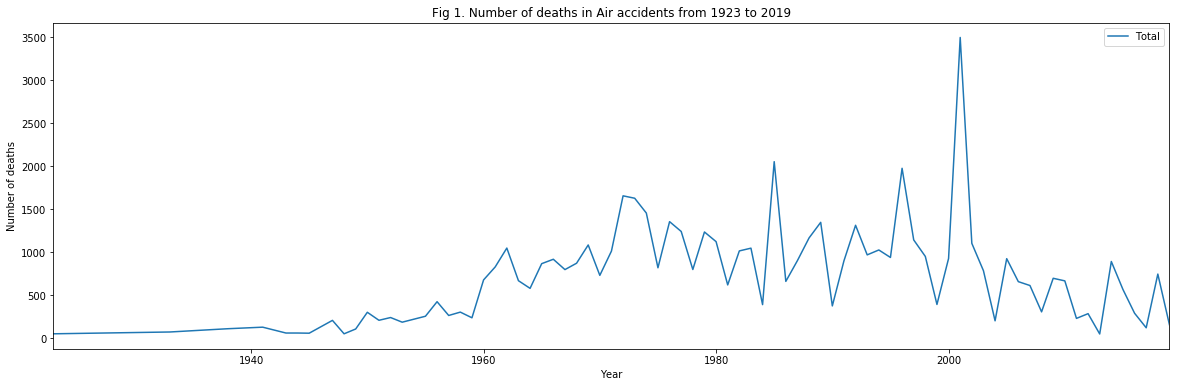

In [30]:
# plot data
df_year.sort_index().plot( figsize=(20, 6)) #Sort_index df_year before plotting

plt.xlabel('Year') # add to x-label to the plot
plt.ylabel('Number of deaths') # add y-label to the plot
plt.title('Fig 1. Number of deaths in Air accidents from 1923 to 2019') # add title to the plot

#plt.show()

**And in terms of occurrence of accidents:**

In [33]:
df_date['Years'].value_counts().head()

1973    18
1976    16
1972    15
1974    13
1969    13
Name: Years, dtype: int64

The top 5 years where accidents were frequent are:  
* 1973 with 18 accidents  
* 1976 with 16 accidents  
* 1972 with 15 accidents  
* 1974 with 13 accidents  
* 1969 with 13 accidents   

Let's plot those information on a bar plot

In [39]:
# In order to plot, we create the corresponding dataframe with index sorted
df_year1 = pd.DataFrame(df_date['Years'].value_counts())
df_year1.index.name = 'Years'
df_year1.columns = ['Total']
df_year1.sort_index(inplace = True)
df_year1.head()

,Total
Years,
1923,1
1933,1
1938,2
1941,1
1943,1


Text(0.5, 1.0, 'Fig2. Number of accidents / incidents from 1923 to 2019')

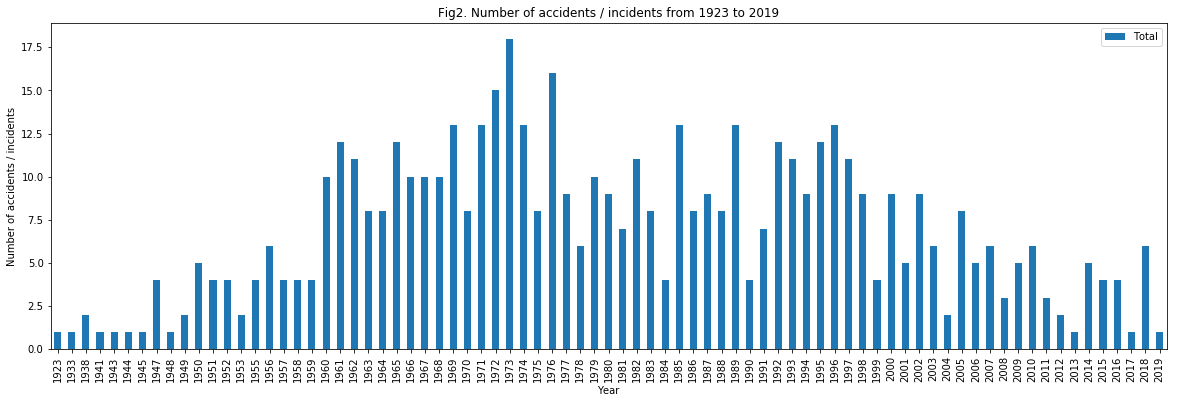

In [35]:
# plot data
df_year1.plot(kind='bar',figsize=(20, 6))

plt.xlabel('Year') # add to x-label to the plot
plt.ylabel('Number of accidents / incidents') # add y-label to the plot
plt.title('Fig2. Number of accidents / incidents from 1923 to 2019') # add title to the plot

**3.2.7.  How about the decades?**

Let's build the dataframe with decades

Let's define the variable 'Decade'

In [36]:
# We define the decades
Decade = ["{0}s".format(year) for year in range(1920,2020,10)]
Decade

['1920s',
 '1930s',
 '1940s',
 '1950s',
 '1960s',
 '1970s',
 '1980s',
 '1990s',
 '2000s',
 '2010s']

Now we create the column 'Decade'in our dataframe

In [37]:
# Create the column 'Decade'
df_date['Decade'] = pd.cut(x=df_date['Years'], bins = len(Decade), labels = Decade)

In [38]:
df_date.head()

,Date,Total,Years,Decade
0,2001-09-11,2889,2001,2000s
1,1977-03-27,583,1977,1970s
2,1985-08-12,520,1985,1980s
3,1996-11-12,349,1996,1990s
4,1974-03-03,346,1974,1970s


Let's group the decades

In [39]:
df_decade = df_date.groupby(['Decade'])[['Total']].sum().sort_values(by = 'Total',ascending = False)
df_decade.head()

,Total
Decade,
1970s,11309
2000s,9713
1990s,9609
1980s,9578
1960s,8580


**In terms of number of people killed:**  
The darkest decade is 1970s with about 11309 people killed

Let's view this on a figure: 

Text(0.5, 1.0, 'Fig3. Number of deaths in air accidents between 1920s and 2010s')

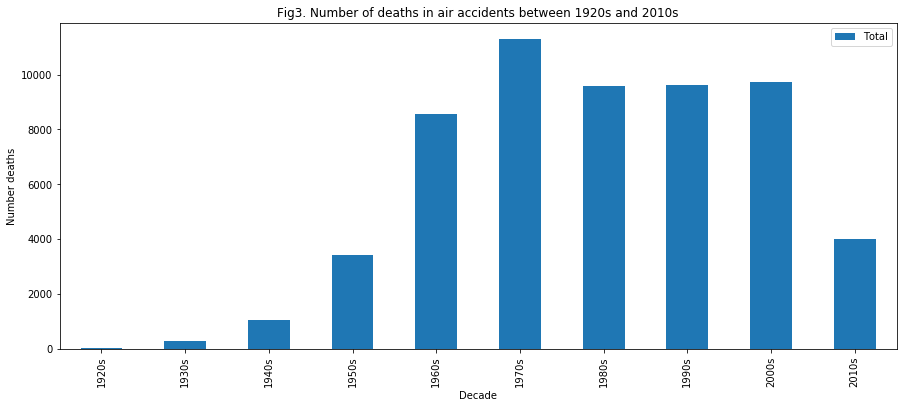

In [40]:
# plot data
df_decade.sort_index().plot(kind='bar',figsize=(15, 6))

plt.xlabel('Decade') # add to x-label to the plot
plt.ylabel('Number deaths') # add y-label to the plot
plt.title('Fig3. Number of deaths in air accidents between 1920s and 2010s') # add title to the plot

**And in terms of occurrence of accidents:**  

In [41]:
df_decade1 = pd.DataFrame(df_date['Decade'].value_counts())
df_decade1.index.name = 'Decade'
df_decade1.columns = ['Total']
df_decade1.sort_index(inplace = True)
df_decade1

,Total
Decade,
1920s,1
1930s,4
1940s,19
1950s,50
1960s,103
1970s,104
1980s,85
1990s,88
2000s,58


The 1960s and 1970s have seen the greatest number of occurences of accidents

Let's visualize it

Text(0.5, 1.0, 'Fig4. Number of accidents/incidents between 1920s and 2010s')

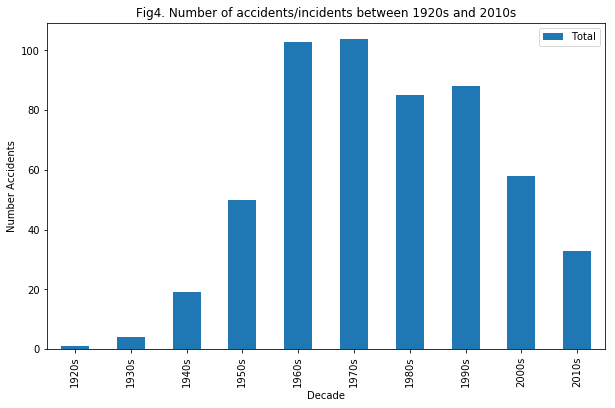

In [42]:
# plot data
df_decade1.plot(kind='bar',figsize=(10, 6))

plt.xlabel('Decade') # add to x-label to the plot
plt.ylabel('Number Accidents') # add y-label to the plot
plt.title('Fig4. Number of accidents/incidents between 1920s and 2010s') # add title to the plot

**3.2.8. What are the top 5 locations that recorded the highest number of deaths?**

This is our main concern in this notebokk, and we wwill be focussing on those locations

In [214]:
df_accident.groupby('Location')['Total'].sum().sort_values(ascending = False).head()

Location
USSR                             3451
New York City, New York, U.S.    2700
Tenerife, Spain                   583
Ueno, Japan                       520
 Iran                             495
Name: Total, dtype: int64

The top 5 locations are:  
* **USSR**       with  3451 killed  
* **New York City, New York, U.S.** with 2700 killed   
* **Tenerife, Spain**  with  583 killed  
* **Ueno, Japan** with 520 killed  
* **Iran** with  495  


### **Visualizations**

 Let's create a map of the world with accidents Locations superimposed on top.

In [12]:
# we will center the map on Douala, Cameroon (My country!)
latitude = 4.053739
longitude = 9.664437
# create map of USSR using latitude and longitude values
map_accident = folium.Map(location=[latitude, longitude], zoom_start=2)

# add markers to map
for lat, lng, location, incident,date in zip(df_accident['Latitude'], df_accident['Longitude'], df_accident['Location'], df_accident['Incident'],df_accident['Date']):
    label = '{}, {},{}'.format(incident, location,date)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_accident)  
    
map_accident

* Let's built a dataframe with unique locations and unique coordinates, with the Total being the sum

In [40]:
df_tot = df_accident.groupby(['Location','Latitude','Longitude'])[['Total']].sum().sort_values(by='Total',ascending = False).reset_index()

In [41]:
df_tot.head()

,Location,Latitude,Longitude,Total
0,USSR,18.222304,109.515577,3451
1,"New York City, New York, U.S.",40.712728,-74.006015,2700
2,"Tenerife, Spain",28.293578,-16.621447,583
3,"Ueno, Japan",35.711788,139.776096,520
4,Iran,32.940750,52.947134,495


It's shape is: 

In [46]:
df_tot.shape

(478, 4)

* **Let's focus on just the Top5**

In [42]:
df_top5 = df_tot.head() 
df_top5

,Location,Latitude,Longitude,Total
0,USSR,18.222304,109.515577,3451
1,"New York City, New York, U.S.",40.712728,-74.006015,2700
2,"Tenerife, Spain",28.293578,-16.621447,583
3,"Ueno, Japan",35.711788,139.776096,520
4,Iran,32.940750,52.947134,495


USSR coordinates seem not to be correct. Let's correct it.  
We will set the default for USSR as the one of the Russian capital Moscow.

In [ ]:
# The geograpical coordinate of Moscow are 55.7504461, 37.6174943.
df_top5.loc[0,'Latitude'] = 55.7504461
df_top5.loc[0,'Longitude'] = 37.6174943

Here's our Top5 dataframe:

In [44]:
df_top5

,Location,Latitude,Longitude,Total
0,USSR,55.750446,37.617494,3451
1,"New York City, New York, U.S.",40.712728,-74.006015,2700
2,"Tenerife, Spain",28.293578,-16.621447,583
3,"Ueno, Japan",35.711788,139.776096,520
4,Iran,32.940750,52.947134,495


We can visualize the Top5 locations

In [45]:
# we will center the map on New York
latitude = 40.712728
longitude = -74.006015
# create map of USSR using latitude and longitude values
map_1 = folium.Map(location=[latitude, longitude], zoom_start=1)

# add markers to map
for lat, lng, location,rad in zip(df_top5['Latitude'], df_top5['Longitude'], df_top5['Location'],df_top5['Total']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=rad/100,
        popup=label,
        color='blue',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_1)  
    
map_1

## 4. **EXPLORING THE TOP5 DEADLIEST LOCATIONS**

# Explore and cluster the neighborhoods in The top 5 above locations

### We are going to utilize the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [46]:
# @hidden_cell
CLIENT_ID = 'RXQ4MMWODK2LOAQS5GUC53U4NNIYQTEXXH1JQFTXM1YGAMLE' # My Foursquare ID
CLIENT_SECRET = '0XTLLHI50COSHBPOHK3BYKPMQDWB1G2FTMHTLTBDNDQWYW1S' # My Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Credentials: OK')

Credentials: OK


## Let's Explore Neighborhoods of the Top5

#### Let's create a function to explore all the neighborhoods in our Top5 locations

In [55]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now we write the code to run the above function on each neighborhood and create a new dataframe called *accident_venues*.

In [56]:
accident_venues = getNearbyVenues(names=df_top5['Location'],
                                   latitudes=df_top5['Latitude'],
                                   longitudes=df_top5['Longitude']
                                  )

USSR
New York City, New York, U.S.
Tenerife, Spain
Ueno, Japan
 Iran


#### Let's check the size of the resulting dataframe

In [57]:
print(accident_venues.shape)
accident_venues

(223, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,USSR,55.750446,37.617494,The Kremlin (Кремль),55.751999,37.617734,Government Building
1,USSR,55.750446,37.617494,Cathedral Square (Соборная площадь),55.750677,37.617442,Plaza
2,USSR,55.750446,37.617494,Музеи Московского Кремля,55.751789,37.616477,History Museum
3,USSR,55.750446,37.617494,State Kremlin Palace (Государственный Кремлёвс...,55.751499,37.615622,Concert Hall
4,USSR,55.750446,37.617494,Grand Kremlin Palace (Большой Кремлевский дворец),55.749869,37.615964,Palace
5,USSR,55.750446,37.617494,Kremlin Armory (Оружейная палата),55.749389,37.613329,History Museum
6,USSR,55.750446,37.617494,Aleksandrovskiy Garden (Александровский сад),55.752707,37.613733,Park
7,USSR,55.750446,37.617494,Taynitsky Garden (Тайницкий сад),55.750648,37.620241,Garden
8,USSR,55.750446,37.617494,Red Square (Красная площадь),55.753595,37.621031,Plaza
9,USSR,55.750446,37.617494,Васильевский Спуск,55.751502,37.623332,Plaza


Let's check how many venues were returned for each neighborhood

In [194]:
accident_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"New York City, New York, U.S.",100,100,100,100,100,100
"Tenerife, Spain",2,2,2,2,2,2
USSR,21,21,21,21,21,21
"Ueno, Japan",100,100,100,100,100,100


#### Let's find out how many unique categories can be curated from all the returned venues

In [58]:
print('There are {} uniques categories.'.format(len(accident_venues['Venue Category'].unique())))

There are 109 uniques categories.


##  Analyze Each Neighborhood

In [59]:
# one hot encoding
accident_onehot = pd.get_dummies(accident_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
accident_onehot['Neighborhood'] = accident_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [accident_onehot.columns[-1]] + list(accident_onehot.columns[:-1])
accident_onehot = accident_onehot[fixed_columns]

accident_onehot.head()

,Neighborhood,American Restaurant,Antique Shop,Art Gallery,Art Museum,BBQ Joint,Baby Store,Bakery,Bar,Bed & Breakfast,Beer Bar,Bookstore,Boutique,Boxing Gym,Building,Burger Joint,Burrito Place,Café,Candy Store,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Cosmetics Shop,Coworking Space,Cuban Restaurant,Dance Studio,Discount Store,Donburi Restaurant,Electronics Store,Event Space,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,General Entertainment,Gift Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Juice Bar,Kaiseki Restaurant,Kids Store,Laundry Service,Liquor Store,Martial Arts Dojo,Middle Eastern Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Nail Salon,Noodle House,Outdoor Sculpture,Palace,Paper / Office Supplies Store,Park,Pizza Place,Plaza,Poke Place,Pub,Ramen Restaurant,Restaurant,Sake Bar,Sandwich Place,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Soba Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Steakhouse,Strip Club,Sushi Restaurant,Tempura Restaurant,Thai Restaurant,Tonkatsu Restaurant,Toy / Game Store,Ukrainian Restaurant,Unagi Restaurant,Vegetarian / Vegan Restaurant,Wagashi Place,Waterfront,Wine Shop,Women's Store,Yakitori Restaurant,Yoga Studio
0,USSR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,USSR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,USSR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,USSR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,USSR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [60]:
accident_onehot.shape

(223, 110)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [61]:
accident_grouped = accident_onehot.groupby('Neighborhood').mean().reset_index()
accident_grouped

,Neighborhood,American Restaurant,Antique Shop,Art Gallery,Art Museum,BBQ Joint,Baby Store,Bakery,Bar,Bed & Breakfast,Beer Bar,Bookstore,Boutique,Boxing Gym,Building,Burger Joint,Burrito Place,Café,Candy Store,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Cosmetics Shop,Coworking Space,Cuban Restaurant,Dance Studio,Discount Store,Donburi Restaurant,Electronics Store,Event Space,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,General Entertainment,Gift Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Juice Bar,Kaiseki Restaurant,Kids Store,Laundry Service,Liquor Store,Martial Arts Dojo,Middle Eastern Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Nail Salon,Noodle House,Outdoor Sculpture,Palace,Paper / Office Supplies Store,Park,Pizza Place,Plaza,Poke Place,Pub,Ramen Restaurant,Restaurant,Sake Bar,Sandwich Place,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Soba Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Steakhouse,Strip Club,Sushi Restaurant,Tempura Restaurant,Thai Restaurant,Tonkatsu Restaurant,Toy / Game Store,Ukrainian Restaurant,Unagi Restaurant,Vegetarian / Vegan Restaurant,Wagashi Place,Waterfront,Wine Shop,Women's Store,Yakitori Restaurant,Yoga Studio
0,"New York City, New York, U.S.",0.02,0.01,0.01,0.00,0.00,0.01,0.03,0.01,0.00,0.00,0.01,0.000000,0.01,0.01,0.02,0.01,0.04,0.00,0.00,0.000000,0.00,0.02,0.06,0.00,0.01,0.000000,0.02,0.01,0.01,0.02,0.01,0.00,0.01,0.010000,0.03,0.01,0.02,0.00,0.01,0.000000,0.00,0.00,0.000000,0.01,0.00,0.03,0.02,0.00,0.01,0.00,0.000000,0.000000,0.00,0.030000,0.02,0.00,0.01,0.030000,0.01,0.01,0.01,0.00,0.01,0.01,0.01,0.01,0.01,0.00,0.01,0.01,0.02,0.00,0.00,0.000000,0.00,0.030000,0.02,0.030000,0.01,0.00,0.00,0.01,0.00,0.05,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.01,0.02,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.000000,0.00,0.01,0.00,0.0,0.02,0.01,0.00,0.02
1,"Tenerife, Spain",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.5,0.00,0.00,0.00,0.00
2,USSR,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.095238,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.047619,0.00,0.00,0.00,0.00,0.00,0.047619,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.047619,0.00,0.00,0.00,0.00,0.00,0.047619,0.00,0.00,0.047619,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.095238,0.142857,0.00,0.047619,0.00,0.00,0.00,0.047619,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.095238,0.00,0.047619,0.00,0.142857,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.047619,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
3,"Ueno, Japan",0.01,0.00,0.00,0.02,0.05,0.00,0.00,0.00,0.04,0.02,0.01,0.000000,0.00,0.00,0.00,0.00,0.04,0.01,0.04,0.000000,0.02,0.02,0.01,0.01,0.00,0.010000,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.000000,0.00,0.00,0.00,0.01,0.00,0.000000,0.01,0.01,0.000000,0.00,0.02,0.00,0.00,0.01,0.00,0.01,0.000000,0.000000,0.01,0.000000,0.00,0.01,0.00,0.010000,0.00,0.05,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.01,0.000000,0.01,0.010000,0.01,0.000000,0.00,0.01,0.03,0.01,0.15,0.00,0.02,0.01,0.01,0.01,0.02,0.00,0.01,0.00,0

#### Let's confirm the new size

In [62]:
accident_grouped.shape

(4, 110)

#### Let's print each neighborhood along with the top 5 most common venues

In [63]:
num_top_venues = 5

for hood in accident_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = accident_grouped[accident_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----New York City, New York, U.S.----
                venue  freq
0         Coffee Shop  0.06
1      Sandwich Place  0.05
2                Café  0.04
3                 Gym  0.03
4  Falafel Restaurant  0.03


----Tenerife, Spain----
                 venue  freq
0           Waterfront   0.5
1           Restaurant   0.5
2  American Restaurant   0.0
3  Monument / Landmark   0.0
4                  Pub   0.0


----USSR----
            venue  freq
0           Plaza  0.14
1  History Museum  0.14
2   Historic Site  0.10
3          Palace  0.10
4        Boutique  0.10


----Ueno, Japan----
                 venue  freq
0             Sake Bar  0.15
1  Japanese Restaurant  0.05
2            BBQ Joint  0.05
3      Bed & Breakfast  0.04
4   Chinese Restaurant  0.04




#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [64]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [65]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = accident_grouped['Neighborhood']

for ind in np.arange(accident_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(accident_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"New York City, New York, U.S.",Coffee Shop,Sandwich Place,Café,Falafel Restaurant,Park,Italian Restaurant,Hotel,Gym,Plaza,Bakery
1,"Tenerife, Spain",Restaurant,Waterfront,Furniture / Home Store,Coworking Space,Cuban Restaurant,Dance Studio,Discount Store,Donburi Restaurant,Electronics Store,Event Space
2,USSR,History Museum,Plaza,Palace,Historic Site,Boutique,Concert Hall,Hotel,Event Space,Government Building,Garden
3,"Ueno, Japan",Sake Bar,Japanese Restaurant,BBQ Joint,Café,Chinese Restaurant,Bed & Breakfast,Wagashi Place,Tonkatsu Restaurant,Ramen Restaurant,Yakitori Restaurant


## 5. **CLUSTERING THE TOP5 DEADLIEST LOCATIONS**

## Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 2 clusters.

In [66]:
# set number of clusters
kclusters =2

accident_grouped_clustering = accident_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(accident_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 0, 0], dtype=int32)

We didn't get any information about Iran, the 5th of the top5 locations. Let's drop Iran from df_top5

In [67]:
df_top4 = df_top5.drop(index=4)

In [68]:
df_top4

,Location,Latitude,Longitude,Total
0,USSR,55.750446,37.617494,3451
1,"New York City, New York, U.S.",40.712728,-74.006015,2700
2,"Tenerife, Spain",28.293578,-16.621447,583
3,"Ueno, Japan",35.711788,139.776096,520


Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [69]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

accident_merged = df_top4

# merge accident_grouped with Top5_data to add latitude/longitude for each neighborhood
accident_merged = accident_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Location')

accident_merged.head() # check the last columns!

,Location,Latitude,Longitude,Total,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,USSR,55.750446,37.617494,3451,0,History Museum,Plaza,Palace,Historic Site,Boutique,Concert Hall,Hotel,Event Space,Government Building,Garden
1,"New York City, New York, U.S.",40.712728,-74.006015,2700,0,Coffee Shop,Sandwich Place,Café,Falafel Restaurant,Park,Italian Restaurant,Hotel,Gym,Plaza,Bakery
2,"Tenerife, Spain",28.293578,-16.621447,583,1,Restaurant,Waterfront,Furniture / Home Store,Coworking Space,Cuban Restaurant,Dance Studio,Discount Store,Donburi Restaurant,Electronics Store,Event Space
3,"Ueno, Japan",35.711788,139.776096,520,0,Sake Bar,Japanese Restaurant,BBQ Joint,Café,Chinese Restaurant,Bed & Breakfast,Wagashi Place,Tonkatsu Restaurant,Ramen Restaurant,Yakitori Restaurant


Finally, let's visualize the resulting clusters

In [71]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster,r in zip(accident_merged['Latitude'], accident_merged['Longitude'], accident_merged['Location'], accident_merged['Cluster Labels'],df_top4['Total']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=r/100,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster.

#### Cluster 1

In [76]:
accident_merged.loc[accident_merged['Cluster Labels'] == 0, accident_merged.columns[[0] + list(range(5, accident_merged.shape[1]))]]

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,USSR,History Museum,Plaza,Palace,Historic Site,Boutique,Concert Hall,Hotel,Event Space,Government Building,Garden
1,"New York City, New York, U.S.",Coffee Shop,Sandwich Place,Café,Falafel Restaurant,Park,Italian Restaurant,Hotel,Gym,Plaza,Bakery
3,"Ueno, Japan",Sake Bar,Japanese Restaurant,BBQ Joint,Café,Chinese Restaurant,Bed & Breakfast,Wagashi Place,Tonkatsu Restaurant,Ramen Restaurant,Yakitori Restaurant


#### Cluster 2

In [77]:
accident_merged.loc[accident_merged['Cluster Labels'] == 1, accident_merged.columns[[0] + list(range(5, accident_merged.shape[1]))]]

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Tenerife, Spain",Restaurant,Waterfront,Furniture / Home Store,Coworking Space,Cuban Restaurant,Dance Studio,Discount Store,Donburi Restaurant,Electronics Store,Event Space


THANK YOU!!!